**X-Ray classification**

**Deep augmentation**

**70 epochs**

**all**

* **densenet**

# Libraries

In [14]:
import tensorflow as tf
import lib.data_loader as data_loader
import lib.plot_learning_curves as plot_learning_curves
import models.base_model as base_model
import models.densenet as densenet
import models.resnet as resnet
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
import json

# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
! pip install -q -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version 2.4.0


# Data  munging

In [15]:
# mount data
data_path = 'data/MURA-v1.1/'
directory = 'data/'
train, test, bodyparts, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader(data_augmentation='deep_augment')


Import train and test data


Create dictionary for training and validation set per body part

Doing a light data augmentation

Create dictionary for training, validation and test set per body part

Found 4446 validated image filenames.
Found 485 validated image filenames.
Found 465 validated image filenames.
Found 8782 validated image filenames.
Found 970 validated image filenames.
Found 659 validated image filenames.
Found 1150 validated image filenames.
Found 122 validated image filenames.
Found 288 validated image filenames.
Found 5014 validated image filenames.
Found 529 validated image filenames.
Found 460 validated image filenames.
Found 4587 validated image filenames.
Found 519 validated image filenames.
Found 461 validated image filenames.
Found 7493 validated image filenames.
Found 886 validated image filenames.
Found 563 validated image filenames.
Found 1639 validated image filenames.
Found 186 validated image filenames.
Found 301 validated image filenames.
Data munging comp

# DenseNet

In [16]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [17]:
def build_model_on_densenet(hp, conv_dropout=True):

    #########################################
    ## set hyperparameters for fine tuning ##
    #########################################

    # tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[5*1e-4, 5*1e-1, 1e-3])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # dropour rate
    dropout_rate = hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.2)

    np.random.seed(1000) # Define the seed for numpy to have reproducible experiments.
    set_seed(150) # Define the seed for Tensorflow to have reproducible experiments.

    ###################
    ## define model ##
    ###################    
    # DenseNet model
    densenet_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                                        input_shape = (320,320,3),
                                                        include_top = False)
    densenet_model.trainable = False
    # add new model on top
    inputs = tf.keras.Input(shape=(320,320,3))
    x = densenet_model(inputs, 
                        training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)    

    outputs = tf.keras.layers.Dense(1, 
                                      activation='sigmoid')(x)
    model = tf.keras.Model(inputs, 
                           outputs)
    model.summary()

    # train the top layer
    model.compile(optimizer = optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['binary_accuracy'])
    return model

In [18]:
# build tuner to fine-tune the hyper-parameters
# for the model
tuner = kt.Hyperband(
                    build_model_on_densenet,
                    objective='val_binary_accuracy',
                    max_epochs=30,
                    hyperband_iterations=2,
                    directory='data/fine_tuner_densenet',
                    project_name='densenet_70_epochs_monitor_val_accuracy'
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [23]:
validation_steps = math.ceil(valid_generators['XR_SHOULDER'].n/ (2*valid_generators['XR_SHOULDER'].batch_size))
print("Using validation_steps = %d" % validation_steps)
steps_per_epoch = math.ceil(train_generators['XR_SHOULDER'].n / (2*train_generators['XR_SHOULDER'].batch_size))
print("Using steps_per_epoch = %d" % steps_per_epoch)

Using validation_steps = 14
Using steps_per_epoch = 118


In [25]:
# define the early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=8)
   
# perfrom search for best parameters
tuner.search(train_generators['XR_SHOULDER'], 
             validation_data=valid_generators['XR_SHOULDER'], 
             epochs=50, 
             callbacks=[stop_early],
             validation_steps=validation_steps,
             steps_per_epoch=steps_per_epoch)

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 09m 40s]
val_binary_accuracy: 0.6808035969734192

Best val_binary_accuracy So Far: 0.6852678656578064
Total elapsed time: 02h 15m 13s
INFO:tensorflow:Oracle triggered exit


In [26]:
print('Learning rate: ', best_hps.get('learning_rate'), ', Dropout rate: ', best_hps.get('dropout'))

Learning rate:  0.0005 , Dropout rate:  0.2


In [27]:
# build the model with the optimal hyperparameters 
# train it on the data for 50 epochs

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generators['XR_SHOULDER'], 
             validation_data=valid_generators['XR_SHOULDER'], 
             epochs=70, 
             callbacks=[stop_early],
             validation_steps=validation_steps,
             steps_per_epoch=steps_per_epoch)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/70
118/118 [==============================] - 314s 3s/step - loss: 0.7296 - binary_accuracy: 0.4914 - v

In [28]:
# plot summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [29]:
# save model

model.save("data/models/finetuned_densenet_70_epochs_deep_augment.h5")
import json
with open("data/history/history_finetuned_densenet_70_epochs_deep_augment.json", "w") as file:
    json.dump(history.history, file)

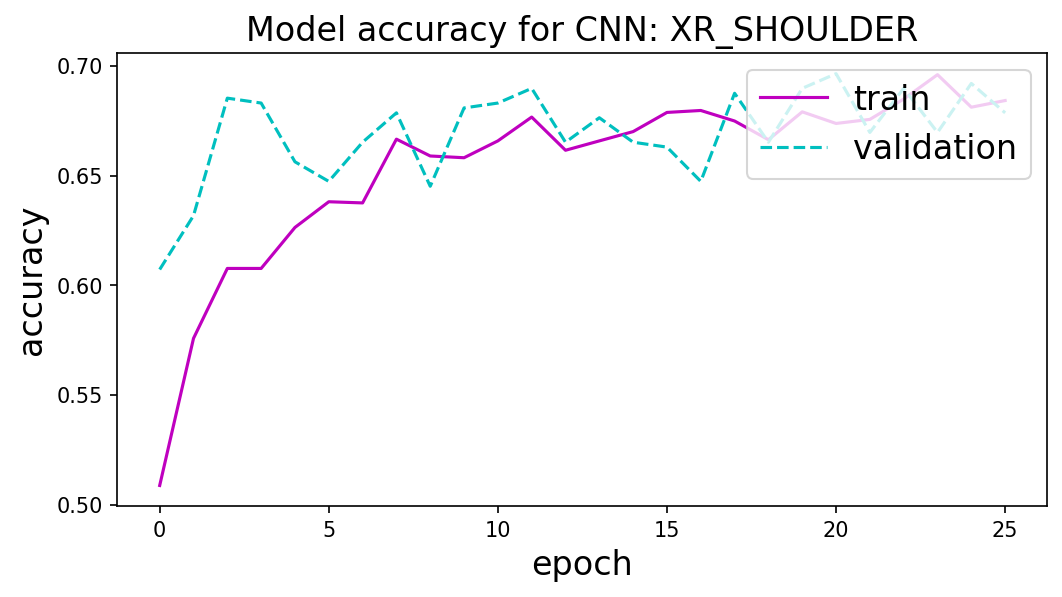

<Figure size 432x288 with 0 Axes>

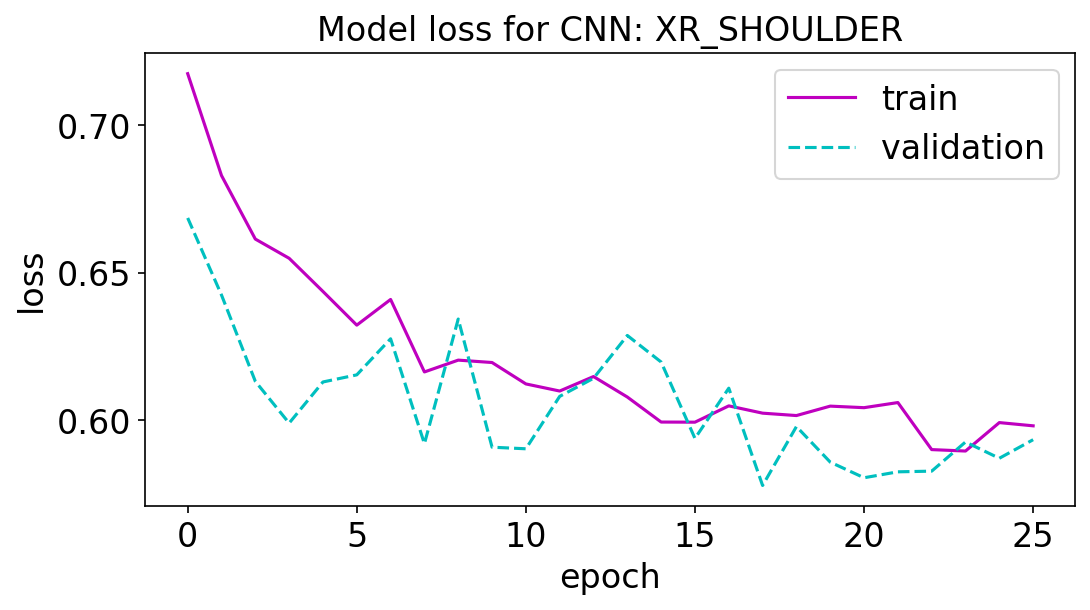

<Figure size 432x288 with 0 Axes>

In [30]:
plot_learning_curves.plot_history(history, 
                                 'XR_SHOULDER',
                                 'finetuned_densenet',
                                 70,
                                 data_augmentation='deep_augment')

In [31]:
def eval_func(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_prob])
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [32]:
bodypart = 'XR_SHOULDER'

In [33]:
eval_func(test[test['bodypart'] == bodypart]['class'], 
                model.predict(test_generators[bodypart]))
test_loss, test_acc  = model.evaluate(test_generators[bodypart], verbose=0)
_, train_acc  = model.evaluate(train_generators[bodypart], verbose=0)
_, valid_acc  = model.evaluate(valid_generators[bodypart], verbose=0)
print("test_loss: ", round(100 * test_loss, 2))
print("test_acc: ", round(100 * test_acc, 2))
print("train_acc: ", round(100 * train_acc, 2))
print("valid_acc: ", round(100 * valid_acc, 2))

Test accuracy: 52.22 %
Test F1 score: 51.36 %
Test Precision score: 51.64 %
Test Recall score: 51.08 %


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


test_loss:  57.14
test_acc:  69.98
train_acc:  71.36
valid_acc:  67.38
